# Modify VAE_CartPole.2.1 from one frame into temporal process.

Ref: *pytorch-mnist-VAE-master, VAE_CartPole.2.1*

In [1]:
# for VAE
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# for Gym env
import pickle
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torchvision
import torchvision.transforms as T

import ipdb

bs = 32
env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
plt.ion()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Extract screemshot for cartpole env, form train-valid dataset CartPole_data.

Ref: *DQN_CartPole.ipynb*

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class CartPole_data(object):
    
    def __init__(self, file_name, capacity=1):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.file_name = file_name
        
    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def save(self):
        with open(self.file_name, 'wb') as file:
            pickle.dump(self.memory, file)
            
    def load(self):
        with open(self.file_name, 'rb') as file:
            self.memory = pickle.load(file)
        
    def sample(self, batch_size, h):
#         if len(self.memory) < self.capacity:
#             print(len(self.memory))
#             print(self.capacity)
#             self.load()
#             print('loaded')
#             print(len(self.memory))
        
        # randomly sample a batch of time series data, with horizon h
        samples = []
#         dones = []
        i = batch_size
        while(i > 0):
            done = False
            index = random.randint(0, len(self.memory) - 1 - h)
            for triple in self.memory[index : index + h]:
                if type(triple.next_state) == type(None):
                    done = True
                    break
            if not done:
                i = i - 1
                samples = samples + self.memory[index : index + h]
#                 dones = dones + [type(triple.next_state) for triple in self.memory[index : index + h]]
        return samples
    
#             indexs = random.sample(range(len(self.memory)), batch_size)
#         return [self.memory(index:index + u) for index in indexs]
    
    def read(self, batch_size, num):
        return self.memory[num * batch_size: (num + 1) * batch_size - 1]
    
    def __len__(self):
        return len(self.memory)
    
    def get_len(self):
        return len(self.memory)

In [3]:
a = None
b = torch.range(0,10)
type(b)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  


torch.Tensor

In [4]:
a = list(range(10))
b = [0, 5]

[a[index : index + 4] for index in b]
c = []
c = c + a[1:4]
c

[1, 2, 3]

In [5]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    
#     cart_location = get_cart_location(screen_width)
#     if cart_location < view_width // 2:
#         slice_range = slice(view_width)
#     elif cart_location > (screen_width - view_width // 2):
#         slice_range = slice(-view_width, None)
#     else:
#         slice_range = slice(cart_location - view_width // 2,
#                             cart_location + view_width // 2)

    slice_range = slice((screen_width - view_width) // 2,
                        (screen_width + view_width) // 2)
    
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = screen.mean(axis=0)
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)

screen shot size:  torch.Size([1, 1, 40, 90])
img_flatten_size:  3600


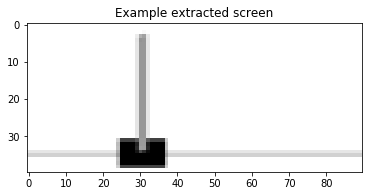

In [6]:
env.reset()
plt.figure()
plt.imshow(get_screen().cpu()[0,0,:].numpy(), cmap='gray')
img_flatten_size = get_screen().shape[2] * get_screen().shape[3]
print('screen shot size: ', get_screen().shape)
img_width = get_screen().shape[3]
print('img_flatten_size: ', img_flatten_size)
plt.title('Example extracted screen')
plt.show()

In [7]:
def data_generation(file_name='CartPole_data_1e5_cart_pole.txt', capacity=1e5, load=False, sample_t=4):
    n_actions = env.action_space.n
    memory = CartPole_data(file_name, capacity)
    
    if load:
        memory.load()
        return memory
    
    thre = 0
    
    while memory.get_len() < capacity:
        # Initialize the environment and state
        env.reset()
        state = get_screen()
        
        for t in count():
            # Select and perform an action
            action = torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)
            _, reward, done, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)

            if t > 80:
                done = True
                
            if done:
                next_state = None
            
            if t % sample_t == sample_t - 1 or done:
                if not done:
                    next_state = get_screen()
                # Store the transition in memory
                memory.push(state, action, next_state, reward)
                # Move to the next state
                state = next_state
            
            if done:
                if memory.get_len() > thre:
                    thre += capacity//10
                    print('\rEpisode {}\tIt Last: {}'.format(memory.get_len() + 1, t + 1))
                    print(thre)
                break

    memory.save()
    print('------Complete-----')
    env.render()
    env.close()
    print(type(memory))
    return memory

## Loading or generating training and testing data

In [8]:
# train_data = data_generation(file_name='CartPole_data_1e5_cart_pole.txt', num_episodes=50000)
# train_data = data_generation(file_name='CartPole_data_3e4_cart_pole.txt', load=True)
train_data = data_generation(file_name='CartPole_data_1e3_st5.txt', load=True)
# train_data = data_generation(file_name='CartPole_data_1e5_st5.txt', load=True)
# train_data = data_generation(file_name='CartPole_data_test_5e3_cart_pole.txt', load=True)
# test_data = data_generation(file_name='CartPole_data_test_5e3_cart_pole.txt', num_episodes=2500)
# test_data = data_generation(file_name='CartPole_data_test_1e3_cart_pole.txt', load=True)
test_data = []

In [9]:
type(train_data)

__main__.CartPole_data

## Variational Auto Encoder

In [22]:
class VAE(nn.Module):
    def __init__(self, h, x_dim=10, h_dim1=10, h_dim2=10, z_dim=10):
        super(VAE, self).__init__()
        
#         x_dim = x_dim / h    # devide x into h channels
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc61 = nn.Linear(h_dim1, x_dim)
        self.fc62 = nn.Linear(h_dim1, x_dim)
        # latent variable transform part
        self.fc7 = nn.Linear(z_dim * (h - 1), z_dim)    # mu
        self.fc8 = nn.Linear(z_dim, z_dim)    # sigma
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu_e, log_var_e
    
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc61(h)), self.fc62(h) # mu_d, log_var_d
    
    def mu_t(self, z_bs):
        return self.fc7(z_bs)
    
    def log_var_t(self):
        return self.fc8(torch.ones(z_dim).to(device))    #???
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
    
    def forward(self, x):
        mu_e, log_var_e = self.encoder(x.view(-1, img_flatten_size))
        z = self.sampling(mu_e, log_var_e)
        mu_d, log_var_d = self.decoder(z)
        mu_t = self.mu_t(torch.index_select(z.view(bs, -1), 1, torch.arange(0, z_dim * (h - 1)).long().to(device)))
        return mu_e, log_var_e, mu_d, log_var_d, \
               mu_t, self.log_var_t()

In [11]:
beta = 20
is_temperal = True

# Variational bottleneck for temperal sequence
if is_temperal:
    print("Variational bottleneck for temperal sequence.")
    def loss_function(x, mu_e, log_var_e, mu_d, log_var_d, mu_t, log_var_t):
#         # reconstruction error
#         ReconL = -0.5 * ((x - mu_d) * (x - mu_d) / log_var_d.exp()).sum()
        # reconstruction error
        ReconL = -F.binary_cross_entropy(mu_d, x.view(-1, img_flatten_size), reduction='sum')
        # entropy
#         betaH = 
        #KL
        betaKL = 0.5 * beta * ((1 + log_var_e).sum() -  (1 + log_var_e[h-1::h]).sum() \
                               - log_var_e.exp().sum() + log_var_e[h-1::h].exp().sum() \
                               - mu_e.pow(2).sum() + mu_e[h-1::h].pow(2).sum())
        # transition error
#         TransL = 0.5 * beta * (log_var_e[h-1::h] + 1 - log_var_t - (mu_e[h-1::h] - mu_t).pow(2) \
#                                 / log_var_t.exp()).sum()
        Elog_p = log_var_e[h-1::h] + 1
        Elog_q = log_var_t \
                 +(log_var_e[h-1::h].exp() + mu_e[h-1::h].pow(2) \
                 - 2 * mu_e[h-1::h] * mu_t + mu_t.pow(2)) \
                 / (log_var_t.exp() + 1e-15)
        TransL = 0.5 * beta * (Elog_p - Elog_q).sum()
#         betaH *= 0
#         return -(ReconL + TransL + betaH + betaKL), -ReconL, -TransL, -betaH, -betaKL
        return -(ReconL + TransL + betaKL), -ReconL, -TransL, torch.Tensor([0]), -betaKL

# Variational bottleneck for i.i.d. data
else:
    print("Variational bottleneck for i.i.d. data.")
    def loss_function(x, mu_e, log_var_e, mu_d, log_var_d, mu_t, log_var_t):
        REC = -F.binary_cross_entropy(mu_d, x.view(-1, img_flatten_size), reduction='sum')
        KLD = 0.5 * beta * (1 + log_var_e - log_var_e.exp() - mu_e.pow(2)).sum()
        return -(REC + KLD), -REC, torch.Tensor([0]), torch.Tensor([0]), -KLD

Variational bottleneck for temperal sequence.


In [12]:
a = torch.arange(1,5)
print(a)
print(a * a)

tensor([1, 2, 3, 4])
tensor([ 1,  4,  9, 16])


In [13]:
a = torch.range(1,3)
a*a
a.sum()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  """Entry point for launching an IPython kernel.


tensor(6.)

In [14]:
import torch
a = torch.range(0,12)
a = a[:]
print(a)

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  


In [15]:
def train(epoch, epochs):
    vae.train()
    train_loss, recon_loss, trans_loss, betaH_loss, betaKL_loss = 0, 0, 0, 0, 0
    capacity = train_data.get_len()
    
    for batch_idx in range(capacity // bs):
#         data = data.cuda()
        transitions = train_data.sample(bs, h)
        data = torch.cat(Transition(*zip(*transitions)).state)
        data = data.to(device)
        next_states = torch.cat(Transition(*zip(*transitions)).next_state)
        next_states = next_states[h - 1::h].to(device)
        optimizer.zero_grad()
        
        mu_e, log_var_e, mu_d, log_var_d, mu_t, log_var_t = vae(data)
        with torch.no_grad():
            mu_e_next, log_var_e_next = vae.encoder(next_states.view(-1, img_flatten_size))
            z_next = vae.sampling(mu_e_next, log_var_e_next)
        loss, ReconL, TransL, betaH, betaKL = \
            loss_function(data.view(-1, img_flatten_size), mu_e, log_var_e, \
                          mu_d, log_var_d, mu_t, log_var_t)

        loss.backward()
        train_loss += loss.item()
        recon_loss += ReconL.item()
        trans_loss += TransL.item()
        betaH_loss += betaH.item()
        betaKL_loss += betaKL.item()
        optimizer.step()
        
    train_loss /= ((capacity // bs)*bs)
    recon_loss /= ((capacity // bs)*bs)
    trans_loss /= ((capacity // bs)*bs)
    betaH_loss /= ((capacity // bs)*bs)
    betaKL_loss /= ((capacity // bs)*bs)

    if epoch % (epochs // 10) == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))
        print('Total Loss', -loss.item())
        print('ReconL, TransL, betaH, betaKL', ReconL.item(), TransL.item(), betaH.item(), betaKL.item())
    return train_loss, recon_loss, trans_loss, betaH_loss, betaKL_loss

In [16]:
# def test(epoch, epochs):
#     vae.eval()
#     test_loss= 0
#     capacity = test_data.get_len()
#     with torch.no_grad():
#         for batch_idx in range(capacity // bs):
# #         for batch_idx in range(3):
# #         data = data.cuda()
#             transitions = test_data.read(bs, batch_idx)
# #             transitions = test_data.sample(bs)
#             data = torch.cat(Transition(*zip(*transitions)).state)
#             data = data.to(device)
#             recon_batch, mu, log_var = vae(data)
#             loss, _, _ = loss_function(recon_batch, data, mu, log_var)
#             test_loss += loss.item()
#     test_loss = test_loss / ((capacity // bs)*bs)
#     if epoch % (epochs // 10) == 0:
#         print('====> Test average loss: {:.4f}'.format(test_loss))
#     return test_loss

In [17]:
def train_plot(epochs):
    train_test_loss_hist = [[], [], [], [], []]
    num = np.arange(0, 5)
    
    for epoch in range(1, epochs + 1):
        train_loss = train(epoch, epochs)
#         test_loss = test(epoch, epochs)
        for item in num:
            train_test_loss_hist[item].append(train_loss[item])
        
#     for loss in train_test_loss_hist:
#         plt.plot(np.arange(1, epochs + 1), loss[:])
    plt.plot(np.arange(1, epochs + 1), train_test_loss_hist[0])
    plt.plot(np.arange(1, epochs + 1), train_test_loss_hist[1])
    plt.plot(np.arange(1, epochs + 1), train_test_loss_hist[2])
    plt.plot(np.arange(1, epochs + 1), train_test_loss_hist[4])
    plt.title('Loss Function History, z_dim={}'.format(z_dim))
#     plt.legend(['train_loss', 'recon_loss', 'trans_loss', 'betaH_loss', 'betaKL_loss'])
    plt.legend(['total_loss', 'reconstruction_loss', 'transition_loss', 'KL_loss'])
    plt.show()
    return train_test_loss_hist

In [18]:
from time import gmtime, strftime
strftime("%Y-%m-%d %H:%M:%S", gmtime())

'2019-08-06 15:52:09'

In [19]:
# rows = 20
# def train_reconstruct():
#     # show the random sampled training set
#     transitions = test_data.sample(rows ** 2)
#     data = torch.cat(Transition(*zip(*transitions)).state)
#     save_image(data.view(rows ** 2, 1, 40, img_width), \
#                    './samples/1training_set' + strftime("%Y-%m-%d %H:%M:%S", gmtime()) + '.png', \
#                    nrow=rows)
    
#     # show the reconstructed imgs correspond to the training set
#     data = data.to(device)
#     optimizer.zero_grad()
#     recon_batch, _, _ = vae(data)
#     save_image(recon_batch.view(rows ** 2, 1, 40, img_width), \
#                    './samples/2reconstruction_training' + strftime("%Y-%m-%d %H:%M:%S", gmtime()) + '.png', \
#                    nrow=rows)

In [20]:
# train_reconstruct()

====> Epoch: 1 Average loss: 4261.7748
Total Loss -73944.5703125
ReconL, TransL, betaH, betaKL 70905.8828125 1332.65380859375 0.0 1706.0321044921875
====> Epoch: 2 Average loss: 2290.2587
Total Loss -74048.8046875
ReconL, TransL, betaH, betaKL 72802.109375 820.1691284179688 0.0 426.5240173339844
====> Epoch: 3 Average loss: 2213.3451
Total Loss -70534.9375
ReconL, TransL, betaH, betaKL 69927.8359375 515.7687377929688 0.0 91.33456420898438
====> Epoch: 4 Average loss: 2196.9208
Total Loss -68438.25
ReconL, TransL, betaH, betaKL 67866.703125 522.3682861328125 0.0 49.18263244628906
====> Epoch: 5 Average loss: 2159.8134
Total Loss -67875.640625
ReconL, TransL, betaH, betaKL 67109.796875 543.3793334960938 0.0 222.46029663085938
====> Epoch: 6 Average loss: 2110.4121
Total Loss -67437.375
ReconL, TransL, betaH, betaKL 64847.1171875 694.769775390625 0.0 1895.481201171875
====> Epoch: 7 Average loss: 2024.8813
Total Loss -64569.37109375
ReconL, TransL, betaH, betaKL 61550.48046875 641.6644287

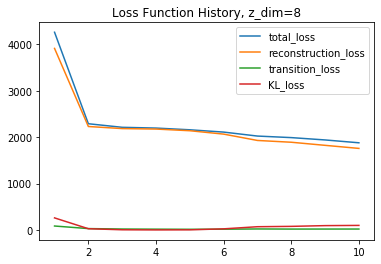

time: 3.4253783226013184s


In [23]:
train_lost_hist = []
z_dims = np.array([8])
h = 5    # !Note: h is horizon + 1

import time

tic = time.time()
for z_dim in z_dims:
    # build model
    vae = VAE(h, x_dim=img_flatten_size, h_dim1=512, h_dim2=256, z_dim=z_dim)
    vae = vae.to(device)
    optimizer = optim.Adam(vae.parameters())
    train_plot(10)
#     train_lost_hist.append(train_plot(100))
#     train_reconstruct()
    
# plt.plot(np.array(train_lost_hist)[:, :, 0].squeeze().transpose())
# plt.title('Train loss for different z_dim')
# legend = ['z_dim=' + str(z_dim) for z_dim in z_dims]
# plt.legend(legend)
# plt.ylim([140, 260])
# plt.show()

toc = time.time()
print("time: " + str(toc - tic) + "s")

In [ ]:
import numpy as np
import time

a = np.random.rand(1000000)
b = np.random.rand(1000000)

tic = time.time()
c = np.dot(a,b)
toc = time.time()

print(c)
print("Vectorized version: " + str(1000*(toc-tic)) + "ms")

c = 0
tic = time.time()
for i in range(1000000):
    c += a[i]*b[i]
toc = time.time()

print(c)
print("For loop: " + str(1000*(toc-tic)) + "ms")

In [ ]:
aa = torch.arange(1,16)
print(aa)
index = torch.arange(0, 4)
print(torch.index_select(aa.view(3, -1), 1, index))
print()

In [ ]:
# # plot training loss for all dims
# plt.plot(np.array(train_lost_hist)[:, :, 0].squeeze().transpose())
# plt.title('Train loss for different z_dim')
# legend = ['z_dim=' + str(z_dim) for z_dim in z_dims]
# plt.legend(legend)
# plt.ylim([140, 260])
# plt.show()

In [ ]:
torch.save(vae.state_dict(), 'vae_data1e5_ep100.pt')

In [ ]:
print("VAE structure: \n", vae)
print("NN for transistion model: \n", list(vae.parameters())[16][:])

In [ ]:
# visualization of the training results of the VAE

vae.eval()
with torch.no_grad():
#     transitions, dones = train_data.sample(bs, h)
    bs = 1000
    transitions = train_data.sample(bs, h)
    data = torch.cat(Transition(*zip(*transitions)).state)
    data = data.to(device)
    mu_e, log_var_e, mu_d, log_var_d, mu_t, log_var_t = vae(data)
    loss, ReconL, TransL, betaH, betaKL = \
        loss_function(data.view(-1, img_flatten_size), mu_e, log_var_e, \
                      mu_d, log_var_d, mu_t, log_var_t)
#     z_h = vae.sampling(mu_t, log_var_t.repeat(bs,1))
#     z_h = vae.sampling(mu_t, torch.ones_like(log_var_t.repeat(bs,1)))
#     mu_h, _ = vae.decoder(z_h)
    mu_h, _ = vae.decoder(mu_t)
    
#     print('Error of transistion z: %6.3f' % (((z_h - mu_e[h-1::h]).pow(2).mean() / z_h.pow(2).mean()).item()))
    print('Error of transistion mu_t: %6.3f' % (((mu_t - mu_e[h-1::h]).pow(2).mean() / mu_t.pow(2).mean()).item()))
    print('Abs Mean value of estimateted z: ',  [round(it, 2) for it in mu_t.abs().mean(0).tolist()])
    print('Sigma of estimated z: ',  [round(it, 2) for it in log_var_t.exp().tolist()])
    
#     cols = bs
#     rows = h
    rows = 4
    cols = h
#     print(dones)
    fig1 = plt.figure(figsize=(12, 7))
    plt.title('Origional images')
    for i in range(1, cols*rows + 1):
        img = data[i - 1].view(40, 90).to('cpu')
        fig1.add_subplot(rows, cols, i)
        plt.imshow(img, cmap='gray')
    plt.show()
    
    alpha = 0.5
    fig2 = plt.figure(figsize=(12, 7))
    plt.title('Reconstruct images')
    for i in range(0, cols*rows):
        if i % h != h -1:
            img = mu_d[i].view(40, 90).to('cpu') #- data[i].view(40, 90).to('cpu') * alpha
        else:
            img = mu_h[int((i + 1) / h - 1)].view(40, 90).to('cpu') - data[i].view(40, 90).to('cpu') * alpha
        fig2.add_subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
    plt.show()

    fig3 = plt.figure(figsize=(12, 7))
    plt.title('Origional images need to be predict')
    for i in range(1, cols*rows + 1):
        img = data[h * i - 1].view(40, 90).to('cpu')
        fig3.add_subplot(rows, cols, i)
        plt.imshow(img, cmap='gray')
    plt.show()

    fig4 = plt.figure(figsize=(12, 7))
    plt.title('Predicted images')
    for i in range(1, cols*rows + 1):
        img = mu_h[i - 1].view(40, 90).to('cpu')
        fig4.add_subplot(rows, cols, i)
        plt.imshow(img, cmap='gray')
    plt.show()

In [ ]:
# visualization for reconstruction when z_dim = 2
variance = 4
if z_dim == 2:
    with torch.no_grad():
        x = np.linspace(-variance, variance, rows)
        y = np.linspace(-variance, variance, rows)
        xv, yv = np.meshgrid(x, y)
        z = np.concatenate((xv.reshape(rows ** 2,1),yv.reshape(rows ** 2,1)), axis=1)
        z = torch.from_numpy(z).float()
        z = z.to(device)
        sample = vae.decoder(z)

        save_image(sample.view(rows ** 2, 1, 40, img_width), \
                   './samples/3reconstruction_z_dim=2' + strftime("%Y-%m-%d %H:%M:%S", gmtime()) + '.png', \
                   nrow=rows)

In [ ]:
# visualization of mu of randomly sampled training set
transitions = train_data.sample(10000)
data = torch.cat(Transition(*zip(*transitions)).state)
data = data.to(device)
vae.eval()
with torch.no_grad():
    recon_batch, mu, log_var = vae(data)
    z = vae.sampling(mu, log_var)
    mu = mu.to('cpu')
    z = z.to('cpu')
    
plt.figure(figsize=(10,10))
plt.scatter(mu[:, 4], mu[:, 5], label='mu', alpha=0.9, s=1)
# plt.scatter(z[:, 0], z[:, 1], label='sample', alpha=0.7, s=1)
plt.legend()
plt.title('Latent variable distribution')
# plt.xlim([-3.5, 3.5])
# plt.ylim([-3.5, 3.5])
plt.show()

In [ ]:
mu.shape

In [ ]:
# vusualization of reconstruction of randomly sampled z
with torch.no_grad():
    z = torch.randn(64, z_dim)
    z = z.to(device)
    sample = vae.decoder(z)
    print(sample.shape)
    save_image(sample.view(64, 1, 40, img_width), './samples/' + strftime("%Y-%m-%d %H:%M:%S", gmtime()) + '.png')